In [1]:
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt
import os
from collections import Counter

In [2]:
K = 14
L = len('Shchapaniak')
X = ((K*L*23) % 20) + 1
Y = ((X + ((K*5 + L*7) % 19)) % 20) + 1

file1 = f'{X:03}.txt'
file2 = f'{Y:03}.txt'
print(f'Files: {file1}, {file2}')

Files: 003.txt, 018.txt


In [3]:
class TextAnalysis:
    def __init__(self, filename):
        with open(filename, 'r', encoding='utf-8') as file:
            self.words = file.read().split()

        self.lens_map = Counter(list(map(len, self.words)))
        self.len_freq = {length: count / len(self.words) for length, count in self.lens_map.items()}

    def plot_word_length_distribution(self):
        lengths, probabilities = zip(*sorted(self.len_freq.items()))
        plt.figure()
        plt.bar(lengths, probabilities)
        plt.title(f'Word Length Distribution in the file 018.txt')
        plt.xlabel('Word Length')
        plt.ylabel('Probability')
        plt.show()

    def estimate_mean_variance(self):
        lengths = np.array([len(word) for word in self.words])
        self.mean = lengths.mean()
        self.variance = lengths.var(ddof = 1)
        self.deviation = np.sqrt(self.variance)
        self.length = len(lengths)

In [4]:
class TwoSampleTTest:
    def __init__(self, text1, text2):
        self.text1 = text1
        self.text2 = text2

    def build_in_test(self):
        lens1 = [len(word) for word in self.text1.words]
        lens2 = [len(word) for word in self.text2.words]
        test_val, p_val = st.ttest_ind(lens1, lens2, alternative = 'two-sided', equal_var=False)
        print(f'Build-in test: test value: {test_val}, p-value {p_val}')

    def calculate_data(self):
        sd2 = self.text1.variance/self.text1.length + self.text2.variance/self.text2.length
        self.nd = sd2**2/((self.text1.variance/self.text1.length)**2/(self.text1.length - 1) + (self.text2.variance/self.text2.length)**2/(self.text2.length - 1))
        self.test = (self.text1.mean - self.text2.mean)/np.sqrt(sd2)

    def test(self, alpha):
        self.calculate_data()
        crit_val = st.t.isf(alpha/2, self.nd)
        p_val = st.t.sf(np.abs(self.test), self.nd) * 2
        print(f'Manual test: critical value: {crit_val}, test value: {self.test}, p-value {p_val}')
        self.build_in_test()

In [5]:
class ChiSquaredTest:
    def __init__(self, text1, text2):
        self.text1 = text1
        self.text2 = text2

    def build_in_test(self):
        test_val, p_val, df, _ = st.chi2_contingency(self.Nij)
        print(f'Build-in test: test value: {test_val}, p-value {p_val}. df: {df}')

    def create_contingency_table(self):
        all_lengths = sorted(set(self.text1.lens_map) | set(self.text2.lens_map))
        table = [[self.text1.lens_map[length], self.text2.lens_map[length]] for length in all_lengths]
        return np.matrix(table)

    def normalize_table(self):
        # not general function, works only for the 003.txt and 018.txt files
        self.Nij[-2] += self.Nij[-1]
        self.Nij = self.Nij[:-1]

    def test(self, alpha, normalize_flag):
        self.Nij = self.create_contingency_table()
        if normalize_flag:
            self.normalize_table()

        n = np.sum(self.Nij)
        pi_, p_j = np.sum(self.Nij, axis = 1)/n, np.sum(self.Nij, axis = 0)/n
        npipj = n * np.matmul(pi_, p_j)

        Chi2  = np.sum(np.square(self.Nij - npipj)/npipj)
        df = (np.size(self.Nij, axis=0) - 1)*(np.size(self.Nij, axis=1) - 1)
        chi2 = st.chi2.isf(alpha, df)
        p_val = st.chi2.sf(Chi2, df)
        print(f'Manual test: critical value: {chi2}, test value: {Chi2}, p-value {p_val}, df: {df}')
        self.build_in_test()

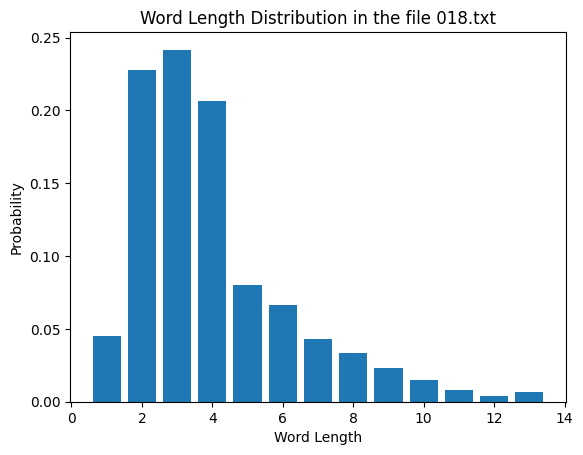

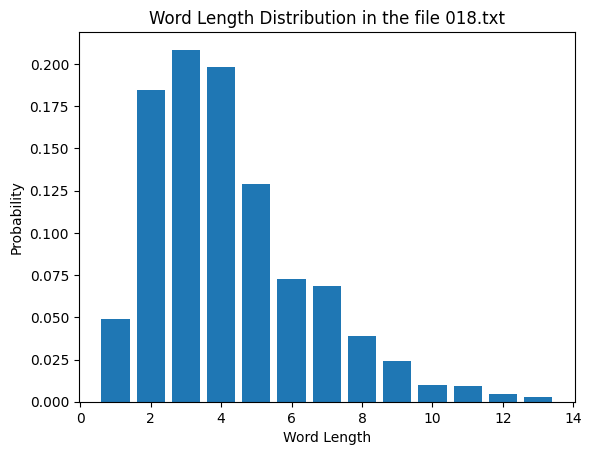

File 003.txt: mean: 3.99317738791423, variance: 5.118977796795511, deviation: 2.262515811391273
File 018.txt: mean: 4.217712177121771, variance: 4.9350137822707865, deviation: 2.2214890911887877
Manual test: critical value: 19.67513757268249, test value: 28.46471075100868, p-value 0.0027465764120750548, df: 11
Build-in test: test value: 28.464710751008685, p-value 0.0027465764120750487. df: 11
Manual test: critical value: 1.9610960399415893, test value: -2.2986205354432054, p-value 0.02162444174917743
Build-in test: test value: -2.2986205354432054, p-value 0.02162444174917743


In [8]:
text1 = TextAnalysis('files/003.txt')
text2 = TextAnalysis('files/018.txt')

text1.estimate_mean_variance()
text2.estimate_mean_variance()

text1.plot_word_length_distribution()
text2.plot_word_length_distribution()

print(f'File 003.txt: mean: {text1.mean}, variance: {text1.variance}, deviation: {text1.deviation}')
print(f'File 018.txt: mean: {text2.mean}, variance: {text2.variance}, deviation: {text2.deviation}')

chi_squared_test = ChiSquaredTest(text1, text2)
chi_squared_test.test(0.05, True)

sample2test = TwoSampleTTest(text1, text2)
sample2test.test(0.05)